# Imports

In [14]:
import os
import librosa
import soundfile as sf
from pydub import AudioSegment
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor
import random
import shutil
INPUT_DIR = "dataset_raw"
OUTPUT_DIR = "dataset"
classes = ["normal", "articulation", "stuttering"]
DATA_DIR = "dataset"


# Introduction

## 1. Project Objective
#### The goal of this project is to develop a model capable of automatically classifying speech defects from short audio samples.  

The initial prototype focuses on binary classification of:
- **normal speech**
- **articulation disorders** (e.g., mispronunciations, phonetic deviations)
- **stuttering**, (CLASS / SEP-28k).  

## 2. Datasets Used

For this project we rely on two primary sources:

### 1. Articulation Disorders Dataset  
Contains recordings of subjects with various articulation impairments.  
Directory example:

`dataset_raw/articulation/M05/Session1/wav_arrayMic/0001.wav`

### 2. Normal Speech Dataset (LibriSpeech Subset) 
Contains clean speech samples from speakers without speech impairments.  
Directory example:

`dataset_raw/normal/dev-clean/batch1/1993/147964/1993-147964-0000.wav`

### 3.


# Dataset Exploration
## Printing directory structure

In [2]:
for root, dirs, files in os.walk(INPUT_DIR):
    print(root)
    print(" Subdirectories:", dirs)
    break  # printing only top-level

dataset_raw
 Subdirectories: ['stuttering', 'articulation', 'normal']


## Loading and displaying waveform

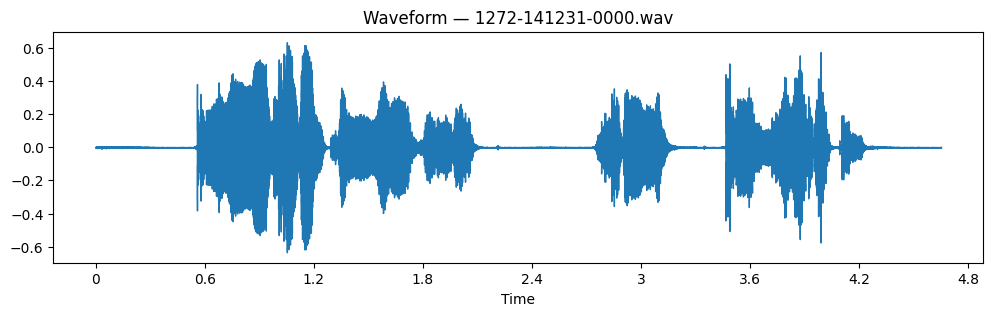

Sampling rate: 16000
Duration (sec): 4.65


In [3]:
sample_path = "dataset_raw/normal/dev-clean/1272/141231/1272-141231-0000.wav"

audio, sr = librosa.load(sample_path, sr=None, mono=True)

plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform — {os.path.basename(sample_path)}")
plt.show()

print("Sampling rate:", sr)
print("Duration (sec):", len(audio) / sr)

## Playing audio sample

In [4]:
Audio(sample_path)

# Data Preprocessing
## Converting to mono and resampling (16 kHz)

In [6]:
def load_audio(path, target_sr=16000):
    try:
        audio, sr = librosa.load(path, sr=target_sr, mono=True)
        return audio, target_sr
    except Exception as e:
        return None, None

## RMS normalization

In [7]:
def normalize_audio(audio, eps=1e-6):
    rms = np.sqrt(np.mean(audio**2) + eps)
    target_rms = 0.03
    return audio * (target_rms / rms)

## Cutting into 3-5 second Chunks

In [8]:
def split_audio(audio, sr, label, min_sec=3, max_sec=5):
    min_len = min_sec * sr
    max_len = max_sec * sr

    if label == "articulation":
        chunks = []
        chunk_len = max_len
        for start in range(0, len(audio), chunk_len):
            chunk = audio[start:start + chunk_len]
            if len(chunk) < min_len:
                continue
            chunks.append(chunk)
        return chunks
    chunks = []
    chunk_len = max_len

    for start in range(0, len(audio), chunk_len):
        chunk = audio[start:start + chunk_len]

        if len(chunk) < min_len:
            continue

        chunks.append(chunk)

    return chunks

## Single file processing function

In [9]:
def process_file(input_path, output_dir, label, errors_log):
    audio, sr = load_audio(input_path)

    if audio is None:
        errors_log.append(f"Failed to load: {input_path}")
        return

    audio = normalize_audio(audio)

    chunks = split_audio(audio, sr, label)

    if len(chunks) == 0:
        errors_log.append(f"No suitable chunks: {input_path}")
        return
    
    # creating directory
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(input_path))[0]
    # saving chunks
    for idx, chunk in enumerate(chunks):
        out_path = os.path.join(class_dir, f"{base_name}_{idx}.wav")
        sf.write(out_path, chunk, sr)

## Main function for preprocessing

In [10]:
def preprocess_dataset(input_root, output_root):
    errors = []
    for label in classes:
        input_path = os.path.join(input_root, label)

        if not os.path.exists(input_path):
            print(f"Missing folder: {input_path}")
            continue
        
        # recursively traversing all subfolders
        for root, dirs, files in os.walk(input_path):
            wav_files = [f for f in files if f.lower().endswith(".wav")]

            for fname in tqdm(wav_files, desc=f"Processing {label}"):
                full_path = os.path.join(root, fname)
                process_file(full_path, output_root, label, errors)

    return errors

errors = preprocess_dataset(INPUT_DIR, OUTPUT_DIR)

Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 16/16 [00:00<00:00, 355.27it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 52/52 [00:00<00:00, 341.60it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 16/16 [00:00<00:00, 280.99it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 64/64 [00:00<00:00, 400.34it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 36/36 [00:00<00:00, 231.79it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 47/47 [00:00<00:00, 296.95it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 31/31 [00:00<00:00, 306.06it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 27/27 [00:00<00:00, 525.56it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 16

## Saving error logs

In [11]:
with open("prep_errors.log", "w") as f:
    for e in errors:
        f.write(e + "\n")

print("Errors logged to prep_errors.log")

Errors logged to prep_errors.log


## Inspecting number of files per class

In [12]:
def count_audio_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len([f for f in files if f.lower().endswith(".wav")])
    return count

normal_count = count_audio_files(os.path.join(OUTPUT_DIR, "normal"))
articulation_count = count_audio_files(os.path.join(OUTPUT_DIR, "articulation"))
stuttering_count = count_audio_files(os.path.join(OUTPUT_DIR, "stuttering"))

print("Normal speech files:", normal_count)
print("Articulation disorder files:", articulation_count)
print("Stuttering files:", stuttering_count)

Normal speech files: 2092
Articulation disorder files: 316
Stuttering files: 1517


## Balancing Dataset

In [15]:
target_count = articulation_count  # 316 файлов

for label in ["normal", "stuttering"]:
    class_dir = os.path.join(OUTPUT_DIR, label)
    all_files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]

    if len(all_files) > target_count:
        to_remove = random.sample(all_files, len(all_files) - target_count)
        for f in to_remove:
            os.remove(os.path.join(class_dir, f))

# Проверка
normal_count = count_audio_files(os.path.join(OUTPUT_DIR, "normal"))
stuttering_count = count_audio_files(os.path.join(OUTPUT_DIR, "stuttering"))
print("Balanced counts:")
print("Normal speech files:", normal_count)
print("Articulation disorder files:", articulation_count)
print("Stuttering files:", stuttering_count)

Balanced counts:
Normal speech files: 316
Articulation disorder files: 316
Stuttering files: 316


# Dataset CSV

In [16]:
data = []
for label in classes:
    class_dir = os.path.join(DATA_DIR, label)
    if not os.path.exists(class_dir):
        continue
    for f in os.listdir(class_dir):
        if f.endswith(".wav"):
            path = os.path.join(class_dir, f)
            data.append([path, label])

df = pd.DataFrame(data, columns=["path", "label"])

train_val, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df["label"])
train, val = train_test_split(train_val, test_size=0.1111, random_state=42, stratify=train_val["label"])  # 10%

train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

print("CSV files: train.csv, val.csv, test.csv")


CSV files: train.csv, val.csv, test.csv


# Data Loader

## Loader preporation

In [17]:
# innitialization
processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

## Dataset class

In [18]:
LABEL2ID = {
    "normal": 0,
    "articulation": 1,
    "stuttering": 2
}

ID2LABEL = {v: k for k, v in LABEL2ID.items()}
NUM_CLASSES = 3

class AudioDataset(Dataset):
    def __init__(
        self,
        csv_path,
        processor,
        target_sr=16000,
        augment=False,
        max_duration_sec=10
    ):
        self.df = pd.read_csv(csv_path)
        self.processor = processor
        self.target_sr = target_sr
        self.augment = augment
        self.max_samples = target_sr * max_duration_sec

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        label = LABEL2ID[row["label"]]

        # load audio
        audio, sr = sf.read(path)
        if audio.ndim > 1:
            audio = audio.mean(axis=1)

        if sr != self.target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=self.target_sr)

        audio = audio.astype(np.float32)

        # hard cut (important for memory)
        if len(audio) > self.max_samples:
            audio = audio[: self.max_samples]

        # simple augmentation
        if self.augment and np.random.rand() < 0.3:
            noise = np.random.randn(len(audio)) * 0.003
            audio = audio + noise

        return {
            "input_values": audio,
            "labels": torch.tensor(label, dtype=torch.long)
        }

## Loading Data

In [19]:
train_dataset = AudioDataset("train.csv", processor, augment=True)
val_dataset   = AudioDataset("val.csv", processor, augment=False)

def collate_fn(batch):
    audios = [item["input_values"] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])

    batch = processor(
        audios,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt",
        return_attention_mask=True
    )

    batch["labels"] = labels
    return batch

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

In [23]:
batch = next(iter(train_loader))

print("input_values:", batch["input_values"].shape)
print("attention_mask:", batch["attention_mask"].shape)
print("labels:", batch["labels"])

input_values: torch.Size([4, 80000])
attention_mask: torch.Size([4, 80000])
labels: tensor([2, 0, 0, 1])


# Model Training

# Evaluation

# Conclusion